# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('ggplot')
sns.set_context('talk') 
sns.set(rc={'figure.figsize':(16, 4)})
# from matplotlib import rc
# rc('text', usetex=True)

import pysam
from pathlib import Path  
from tqdm.notebook import tqdm 
import pandas as pd
import numpy as np
import editdistance

from collections import Counter, defaultdict, namedtuple
from itertools import count 
from more_itertools import pairwise
from operator import itemgetter

In [3]:
from data import *
from viz_utils import *
from core import *
from algo import *
from metrics import *

# Выравнивание

In [4]:
DATA = Path('test_data')
RUNS = Path('runs')

bamfile_path = DATA / 'u5e-8_s2000_Ne500' / 'sequences001' / 'final.bam'
# bamfile_path = DATA / 'gag' / 'gag.sorted.bam'
# bamfile_path = DATA / 'no_recomb' / 'u1.5e-5_s200_Ne1000' / 'sequences00001' / 'reads_pol.sorted.bam'
# bamfile_path =DATA / '/keili_u5e-5_s2000_Ne500_pol/reads.sorted.bam'
# bamfile_path = DATA / 'no_recomb/u1.5e-5_s200_Ne1000/sequences00001/paired_reads.sorted.bam'
# bamfile_path = DATA / 'no_recomb/u2e-5_s200_Ne1000/sequences00001/paired_reads.sorted.bam'
# bamfile_path = DATA / 'no_recomb/u2.5e-5_s200_Ne1000/sequences00001/paired_reads.sorted.bam'
# bamfile_path = DATA / 'no_recomb/u3e-5_s200_Ne1000/sequences00001/paired_reads.sorted.bam'
# bamfile_path = DATA / 'no_recomb/u3.5e-5_s200_Ne1000/sequences00001/paired_reads.sorted.bam'
# bamfile_path = DATA / 'mixlab_to_hxb2' / 'hxb2.sorted.bam'

In [5]:
# reads = load_reads(bamfile_path)
paired_reads, reference_length = load_paired_reads(bamfile_path, 'pol_HXB2', min_mapping_quality=0)

Load reads: 394948it [00:02, 175411.16it/s]

Dropped [not proper pair]: 0
Dropped [supplementary  ]: 0
Dropped [unmapped       ]: 0
Dropped [qcfail         ]: 0
Dropped [mapping quality]: 0
Valid reads: 197474 (single=0, paired=197474)


In [6]:
# TODO chech reference genome length
snps = create_snps_from_aligned_segments(paired_reads, reference_length)

Using reference region: [0, 1139)


SNPs from [AlignedSegment]: 100%|██████████| 197474/197474 [00:55<00:00, 3570.22it/s]

Reference position covered [1139]:[0, 1, 2, 3, 4]..[1134, 1135, 1136, 1137, 1138] 
Reference position out of target region covered [0]:[]..[] 
Positions are out of region: 0
Fail  quality: 0


In [7]:
len(snps)

1139

In [8]:
ref = GenomeReference(snps)

In [9]:
target_snps = SNP.filter(snps, min_minor_coverage=0.006)
len(target_snps)

3

In [10]:
# for snp in snps[:10]:
for snp in target_snps[:10]:
    print(snp)

SNP(pos=144, cov=42841, major_cov=0.9769, nucls=('G', 'A', 'T', 'C'))
SNP(pos=475, cov=68280, major_cov=0.8158, nucls=('G', 'C', 'T', 'A'))
SNP(pos=556, cov=68285, major_cov=0.7565, nucls=('T', 'A', 'C', 'G'))


In [11]:
print(get_unique_nucls(snps))
print(get_unique_nucls(target_snps))

Counter({'C': 1131, 'T': 1129, 'A': 1129, 'G': 1128})
Counter({'G': 3, 'A': 3, 'T': 3, 'C': 3})


Всего: 3


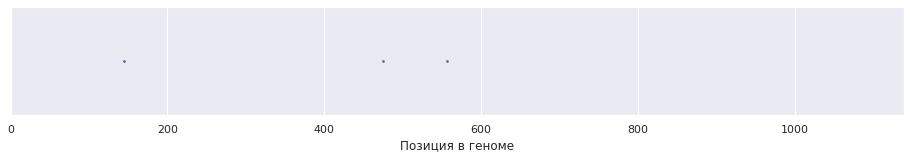

In [12]:
plot_snps_distr(snps, target_snps)

# Анализ данных

      average
0    1.000000
1    1.017021
2    1.008658
3    1.022727
4    1.022727
..        ...
984  1.000000
985  1.000000
986  1.000000
987  1.000000
988  1.000000

[989 rows x 1 columns]
generated data


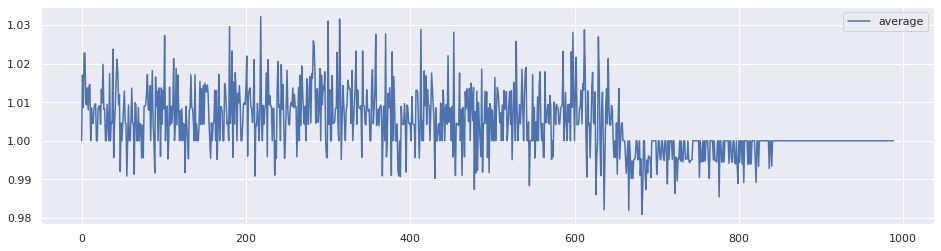

In [14]:
snp_positions = set(snp.position for snp in target_snps)
read_to_snp_count = defaultdict(list)
for read in paired_reads:
    # print(read)
    result = SNP.select_snps_from_paired_read(read, snp_positions, read[0].pos)
    if result is not None:
        positions, nucls = result
        if len(positions) > 0:
            positions_count = len(set(x[0] for x in positions))
            read_to_snp_count[read[0].pos].append(positions_count)
        else:
            read_to_snp_count[read[0].pos].append(0)
data = pd.DataFrame(
    {'average': [sum(x) / len(x) for x in read_to_snp_count.values()]})
print(data)
print('generated data')
data.plot()
# print(positions)

In [15]:
print(snp_positions)

{144, 475, 556}


## Риды 

100%|██████████| 197474/197474 [00:00<00:00, 1210386.09it/s]


Counter({44: 197474})


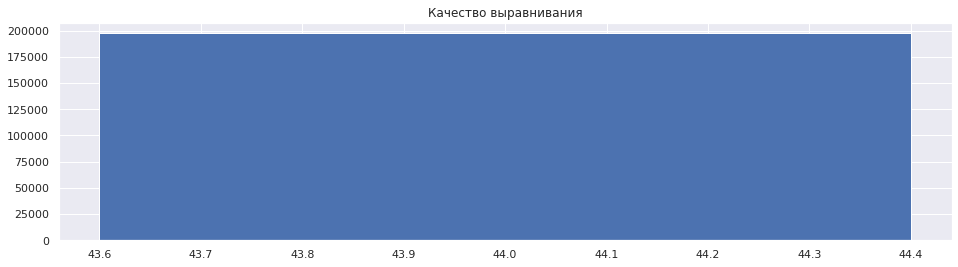

In [15]:
quals = Counter([r1.mapping_quality for r1,r2 in tqdm(paired_reads)])
print(quals)

plt.bar(quals.keys(), quals.values())
plt.title('Качество выравнивания');

In [16]:
reads_stats(bamfile_path)


Total reads : 394948
Unmapped    : 0
Paired      : 394948 (394948)
Proper pair : 394948
Fst read    : 197474
Snd read    : 197474
Names: Counter({2: 197474})



1 in 2      : 29
2 in 1      : 797
1 then 2    : 32768
2 then 1    : 32990
1 overlap 2 : 131716


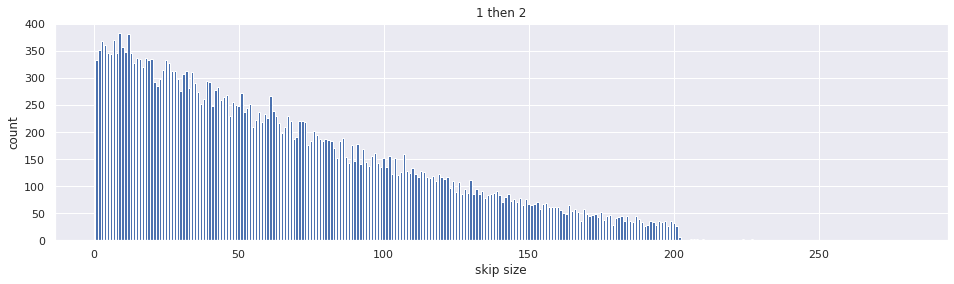

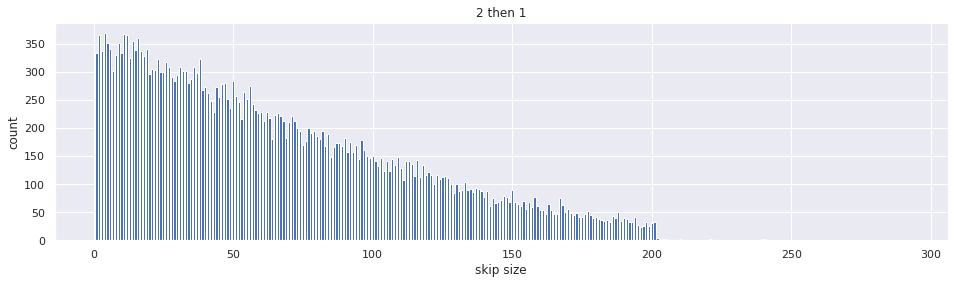

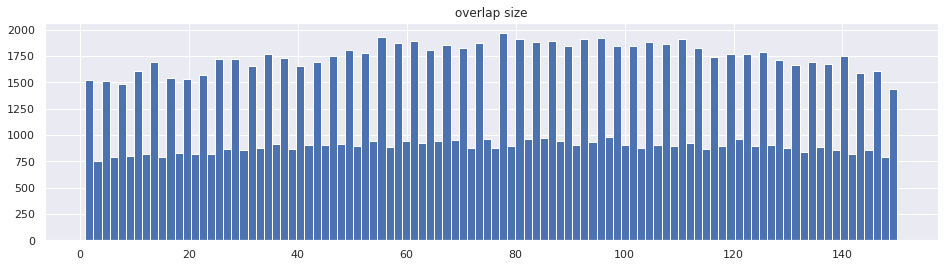

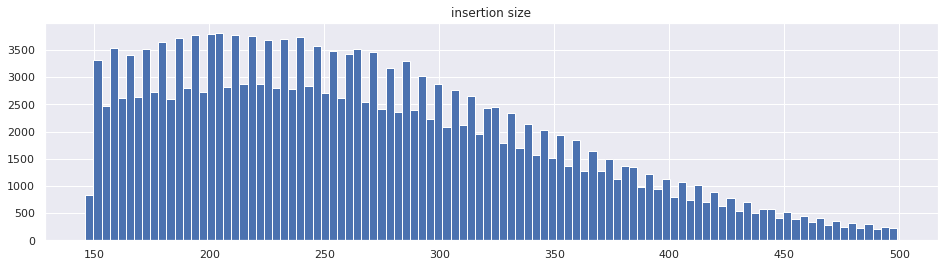

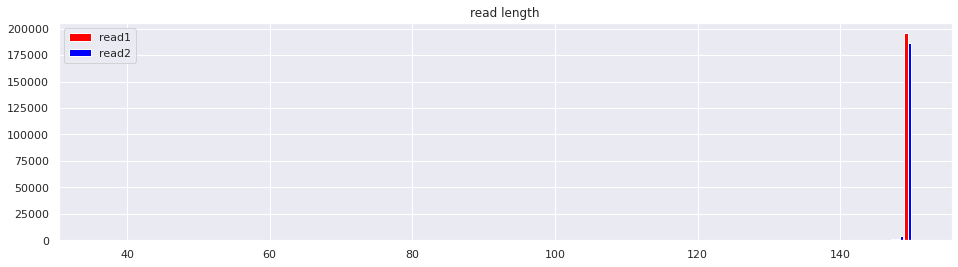

In [17]:
paired_reads_stats(paired_reads)

## Статистика по снипам

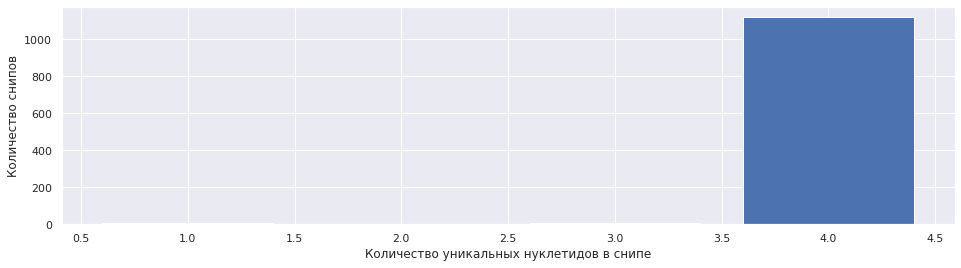

In [18]:
snp_variations = Counter(list(map(len, snps)))
plt.bar(snp_variations.keys(), snp_variations.values())
plt.xlabel('Количество уникальных нуклетидов в снипе')
plt.ylabel('Количество снипов');

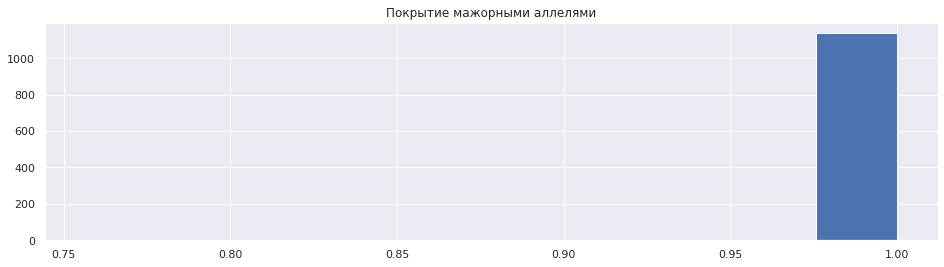

In [19]:
major_coverage = [snp.major_coverage for snp in snps]

plt.hist(major_coverage)
plt.title('Покрытие мажорными аллелями');

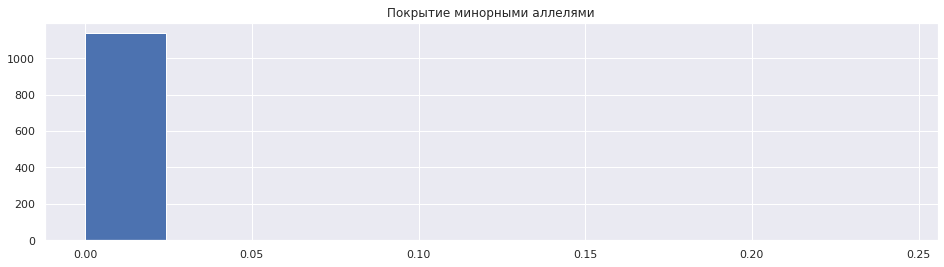

In [20]:
minor_coverage = [snp.minor_coverage for snp in snps]

plt.hist(minor_coverage)
plt.title('Покрытие минорными аллелями');

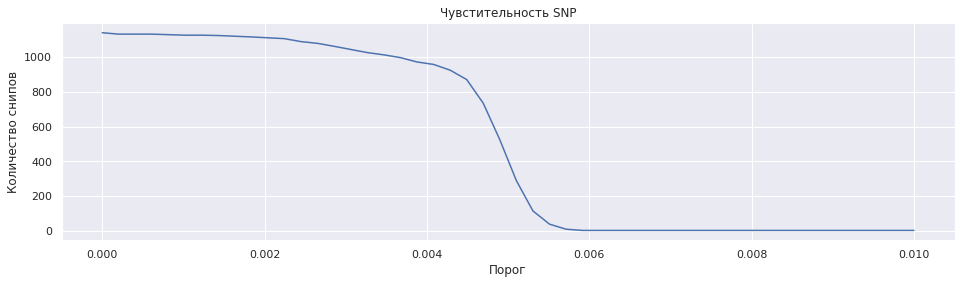

In [21]:
thresholds = np.linspace(0, 0.01, num=50)
snps_count = [
    sum(1 for snp in snps if snp.minor_coverage >= min_cover)
    for min_cover in thresholds
]

plt.plot(thresholds, snps_count)
plt.title('Чувстительность SNP')
plt.ylabel('Количество снипов')
plt.xlabel('Порог')
plt.show()

## Распределение количества позиций от величины покрытия на фиксированную аллель

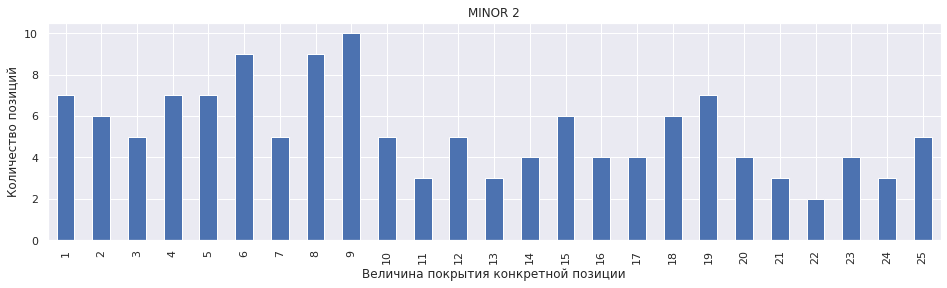

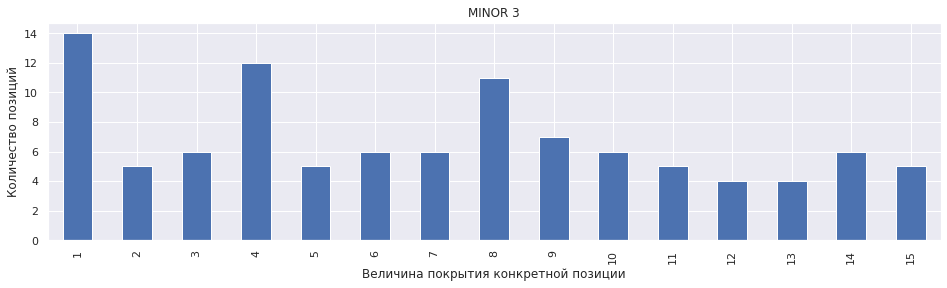

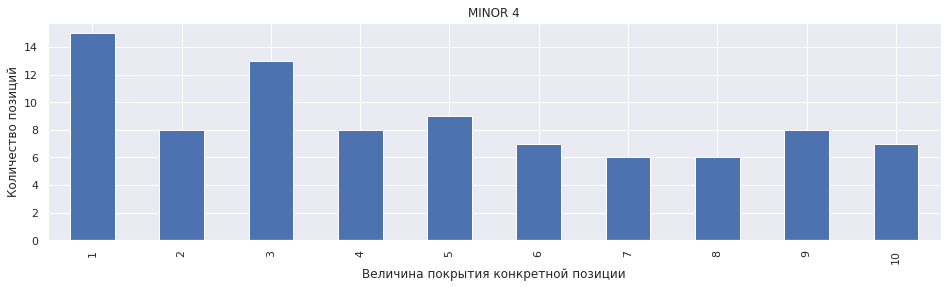

In [23]:
minor2 = get_minor_snps_coverage(snps, minor_order=2)
minor3 = get_minor_snps_coverage(snps, minor_order=3)
minor4 = get_minor_snps_coverage(snps, minor_order=4)

plot_snps_coverage(minor2, 'minor 2', head=25) 
plot_snps_coverage(minor3, 'minor 3', head=15) 
plot_snps_coverage(minor4, 'minor 4', head=10)

# Гипер ребра

## Создание ребер

In [25]:
hedges = create_hedges(paired_reads, target_snps, region_start = 0)
print(f'|HyperEdges| = {len(hedges)}')

Create hedges from reads: 100%|██████████| 197474/197474 [00:10<00:00, 19266.29it/s]

Skipped reads without SNP   : 86977
Skipped reads with holes    : 0
Skipped chimera paired reads: 380
|HyperEdges| = 44


In [28]:
print('By weight:', len([he for he in hedges if he.weight >= 40]))
print('By lenght:', len([he for he in hedges if len(he) >= 200]))
print('By snp_count  :', len([he for he in hedges if he.snp_count >= 3]))

By weight: 15
By lenght: 20
By snp_count  : 9


## Тип

SingleHEdge reads: 42
PairedHEdge reads: 2


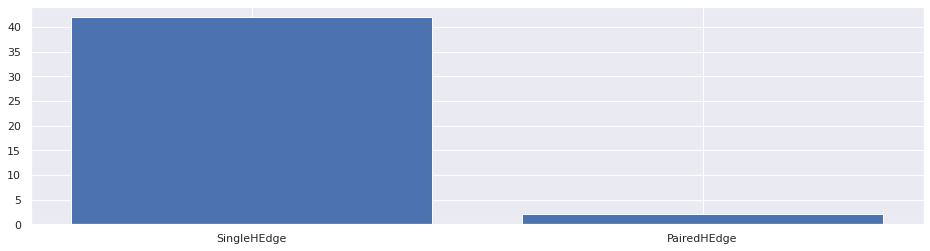

In [29]:
plot_hedges_type_distr(hedges)

## Размер (количество снипов)

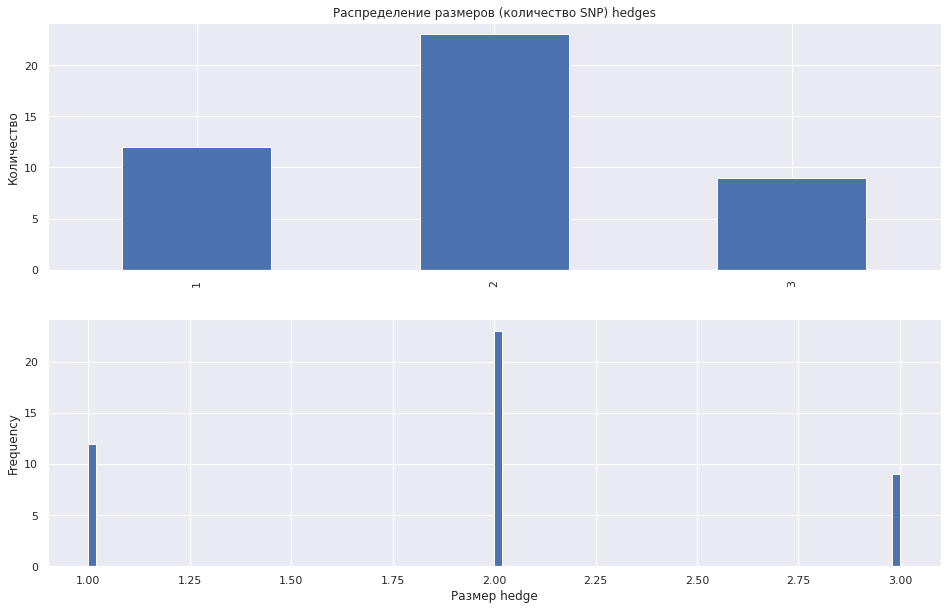

In [30]:
plot_hedges_snp_count_distr(hedges)

## Длина

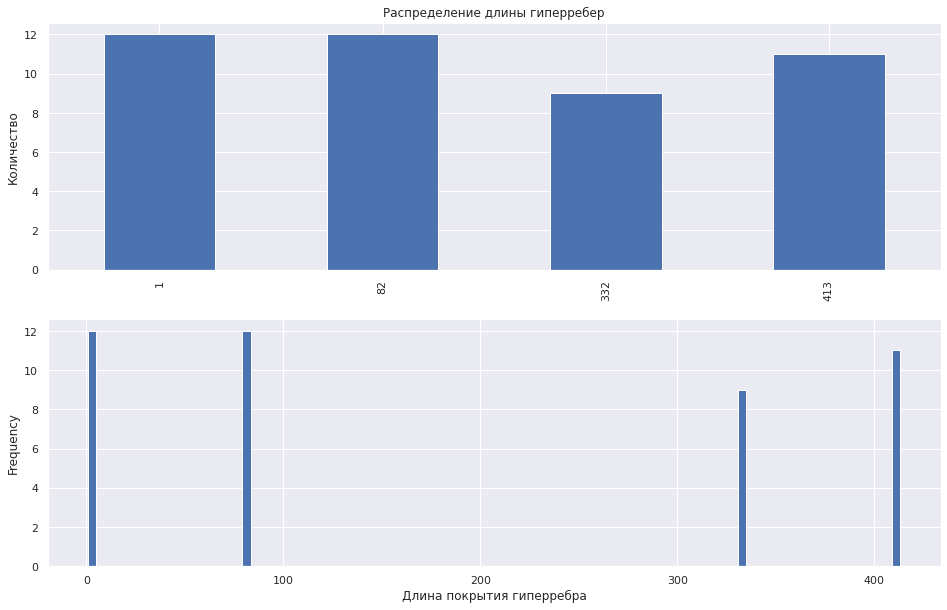

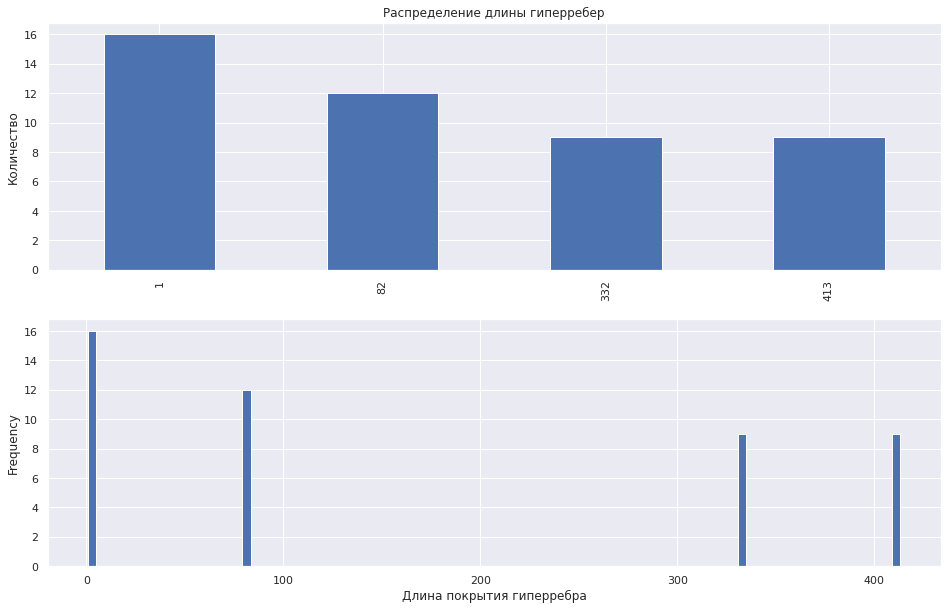

In [31]:
plot_hedges_length_distr(hedges, split_paired_hedges=False)
plot_hedges_length_distr(hedges, split_paired_hedges=True)

## Вес

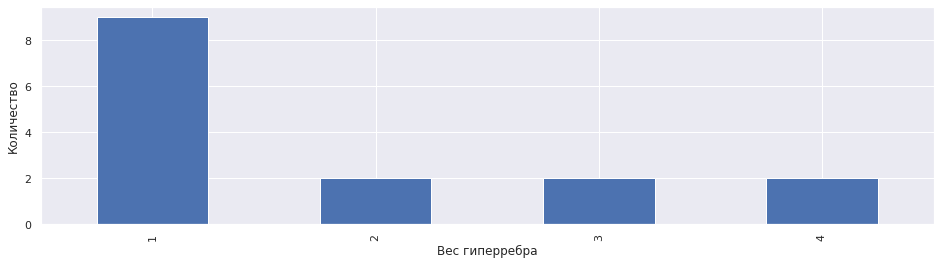

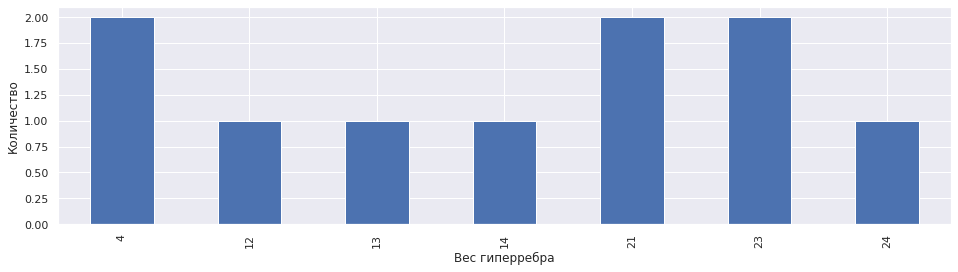

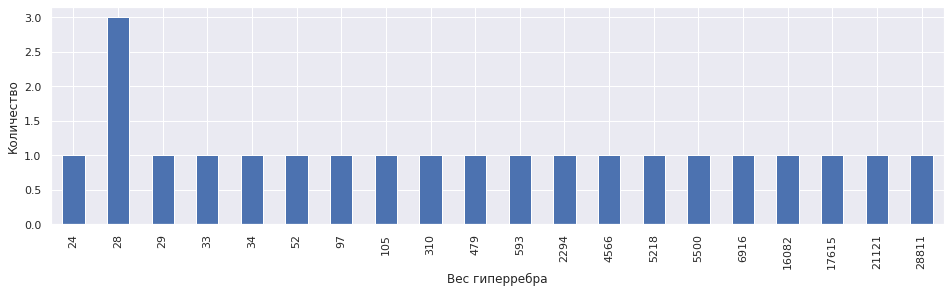

In [32]:
plot_hedges_weight_distr(hedges, upper=4)
plot_hedges_weight_distr(hedges, lower=4, upper=10)
plot_hedges_weight_distr(hedges, lower=10, upper=60)

# plot_hedges_weight_distr(hedges, upper=9)
# plot_hedges_weight_distr(hedges, lower=2, upper=10)
# plot_hedges_weight_distr(hedges, lower=8, upper=60)
# plot_hedges_weight_distr(hedges, lower=-70)

## Покрытие тяжелыми гиперребрами

Used hedges: 31


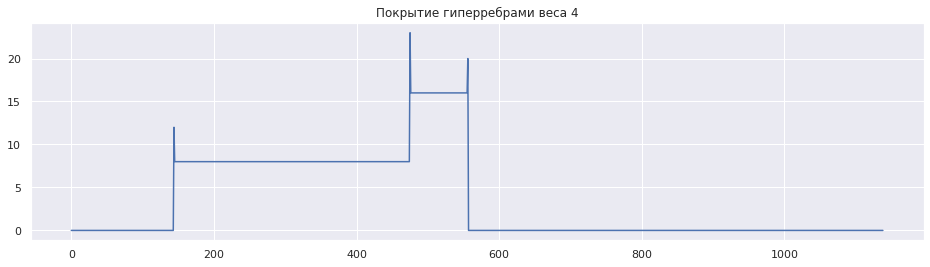

Used hedges: 31


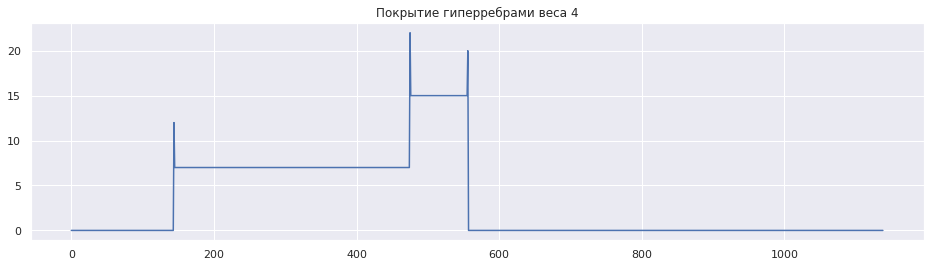

In [33]:
# for thresh in range(10, 100 + 1, 10):
#     plot_coverage(hedges, weight_thresh=thresh, save=True)    

plot_coverage(hedges, reference_len=len(snps), weight_thresh=4, split_paired_hedges=False)
plot_coverage(hedges, reference_len=len(snps), weight_thresh=4, split_paired_hedges=True)

## Соотношение размера (количество снипов) и веса

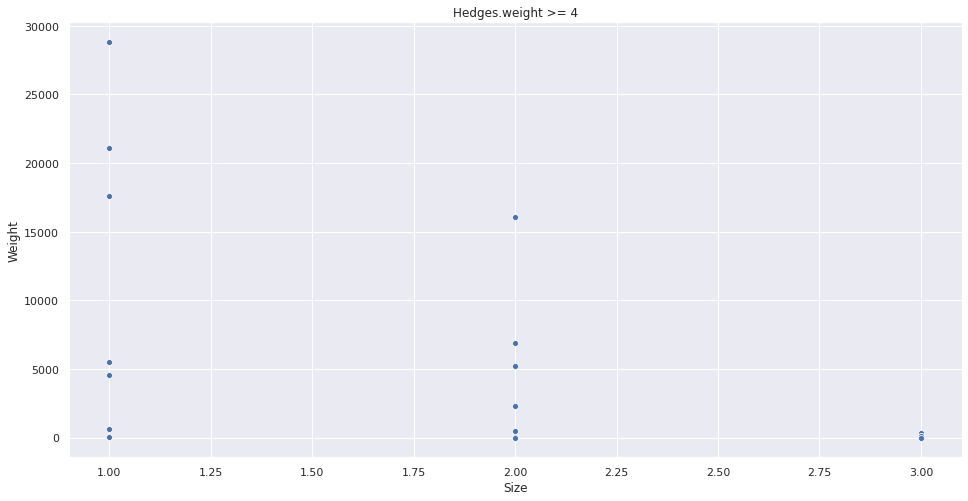

In [34]:
# for thresh in range(10, 50, 10):
#     plot_hedges_snp_count_and_weight_ratio(hedges, weight_thresh_lower=thresh)

plot_hedges_snp_count_and_weight_ratio(hedges, weight_thresh_lower=4)    

# Визуализация гиперграфа (v1)

In [35]:
from viz_utils import HyperGraphViz

test_hgv = HyperGraphViz()
test_hegdes = [
    HEdge(positions = [1,2,4,6], nucls=list('ATTC'), weight=10),
    HEdge(positions = [1,2,4,6], nucls=list('ACTC'), weight=15)
]
for he in test_hegdes:
    test_hgv.add_hedge(he)

# hgv.print_segments()
test_hgv.plot(1, 6, figsize=(16, 5))

TypeError: __init__() got an unexpected keyword argument 'positions'

In [36]:
hgv = HyperGraphViz()
hgv.add_all_hedges(hedges,w_threshold=10)

AttributeError: 'PairedHEdge' object has no attribute 'positions'

In [ ]:
hgv.linewidth = 15
hgv.linewidths = 15

In [ ]:
# hgv.plot(70, 90,save=True)
hgv.plot(70, 90)

In [ ]:
for l, r in pairwise(list(range(0, 1500, 100))): 
#     hgv.plot(l, r,save=True)
    hgv.plot(l, r)

# Run algo and find Haplos 

In [37]:
target_hedges = [he for he in hedges if he.weight >= 4]
len(target_hedges)

31

## Contig merging

Master hedges after merging: 14
Haplo contigs: 14
Used hedges: 14


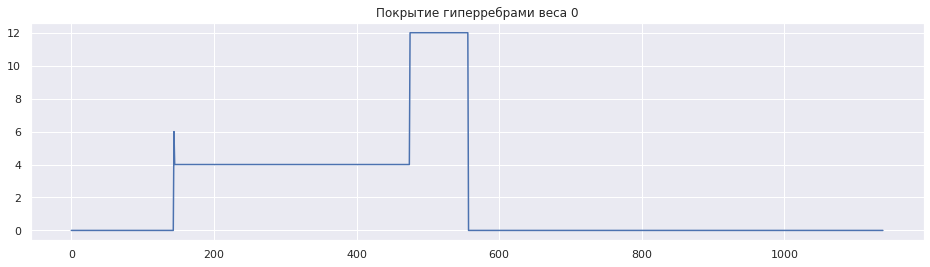

In [39]:
haplo_hedges, metrics_log = algo_merge_hedge_contigs(target_hedges)
print(f'Haplo contigs: {len(haplo_hedges)}')

for metrics_name, metrics_values in metrics_log.items():
    pd.Series(metrics_values).plot.hist()
    plt.title(metrics_name)
    plt.show()
    
plot_coverage(haplo_hedges, weight_thresh=0, reference_len=reference_length)

## Connectivity_graph (in progress)

In [40]:
g, edges_count = create_hedge_connectivity_graph(target_hedges)
vertex_count = len(target_hedges)
print('Verexes count', vertex_count)
print('Edges count', edges_count)


Create vertexes:   0%|          | 0/31 [00:00<?, ?it/s]


AttributeError: 'SingleHEdge' object has no attribute 'is_consistent_with'

In [ ]:
in_deg, out_deg = calc_in_out_deg(g)

# Add source and target vertexes
s, t = 0, vertex_count + 1
for v in range(1, vertex_count + 1):
    if not in_deg[v] and out_deg[v]:
        g[s].append(v)
    if in_deg[v] and not out_deg[v]:
        g[v].append(t)
vertex_count += 2
print('Source vertex count:', len(g[s]))
print('Target vertex count:', len([u for u, vertexes in g.items() if t in vertexes]))

In [ ]:
len(in_deg), len(out_deg), len(set(in_deg) | set(out_deg))

In [ ]:
inv_g = get_inv_graph(g)

In [ ]:
len(g), len(inv_g)

In [ ]:
paths_count = calc_paths_count(inv_g, vertex_count)
print('Total paths count:', paths_count[t])

In [ ]:
dist = calc_graph_depth(g, vertex_count)
print('Shortest path len:', dist[t])

In [ ]:
Counter(dist)

In [ ]:
# edges = algo_hedge_connectivity_graph(target_hedges)

# Метрики

## Размер (количество снипов)

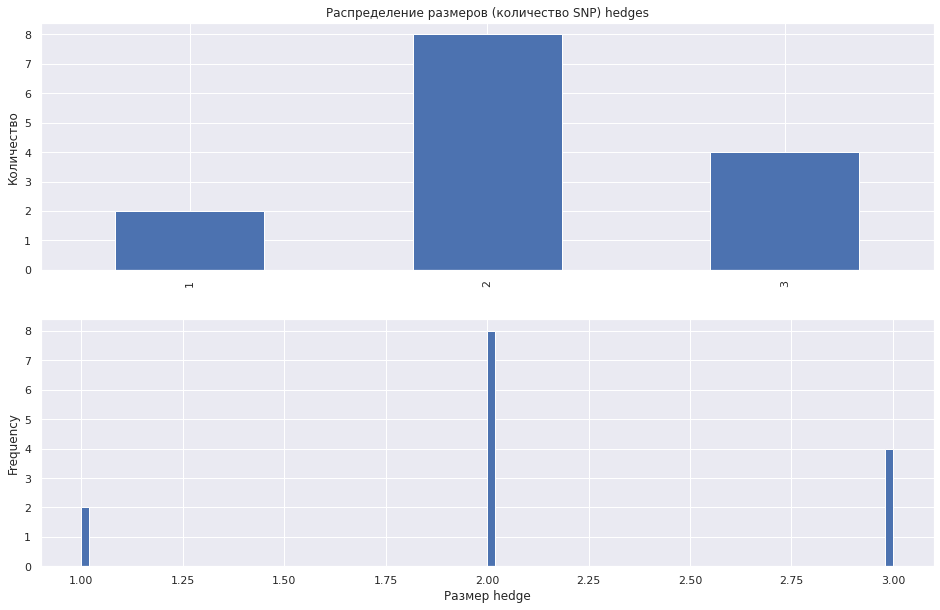

In [41]:
plot_hedges_snp_count_distr(haplo_hedges)

## Длина покрытия референса

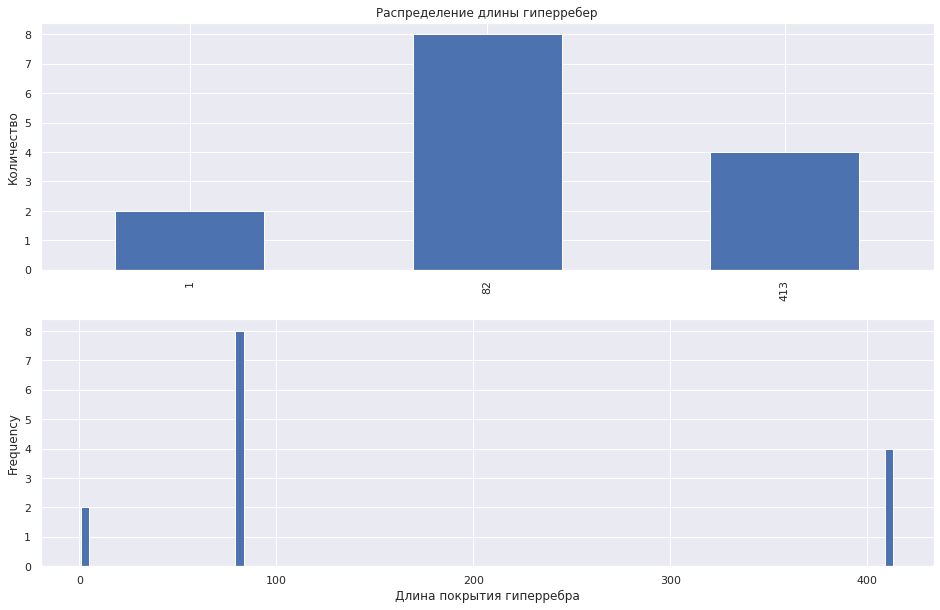

In [42]:
plot_hedges_length_distr(haplo_hedges)

## Покрытие референса

Used hedges: 4


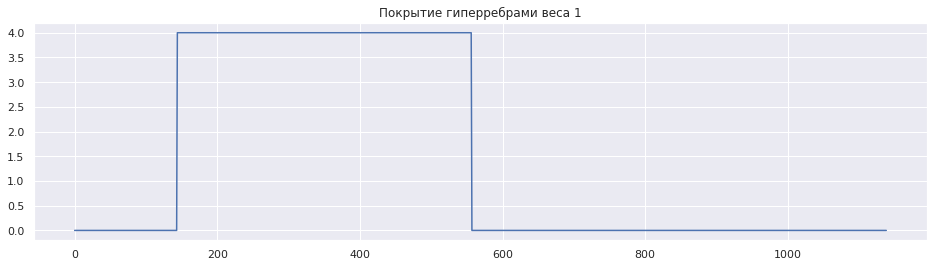

In [46]:
plot_coverage(select_hedges_by_length(haplo_hedges, length_thresh=400), reference_len=reference_length)
# plot_coverage(haplo_hedges)            

# Сравнения с другими тулами

## Дополнение мажорными нуклеотидами

In [ ]:
haplos = padding_contigs_with_major(
    select_hedges_by_length(haplo_hedges, length_thresh=400),
    ref       
)

## CluqueSNV

In [ ]:
mix_haplos = read_labmix_gag()

for h in mix_haplos:
    print(h.name, h.freq, h.nucls[:10])    

In [ ]:
clique_hs_01 = read_clique(RUNS / 'clique-mix5_tf-01/gag.sorted.fasta')

for h in clique_hs_01:
    print(h.name, h.freq, h.nucls[:10])

In [ ]:
print('Mixlab by CliqueSNV')
left_by_right_set_dist(mix_haplos, clique_hs_01)

print()
print('CliqueSNV by Mixlab')
left_by_right_set_dist(clique_hs_01, mix_haplos)

In [ ]:
print('Mixlab by our')
left_by_right_set_dist(mix_haplos, haplos)

print()
print('Our by Mixlab')
left_by_right_set_dist(haplos, mix_haplos)

## Major nucleodite

In [ ]:
major_haplo = Haplotype('major', ref.nucls)

left_by_right_set_dist(mix_haplos, [major_haplo] * len(mix_haplos))

## Gag gene
Mixlab | Major |cliequeSNV | w40_dist |  w20_dist |  w10_dist | 
--- | --- | --- | --- | --- | --- |
   896 | 75 | **46** | 50 | 49 | 62 |
  HXB2 | 28 | 15 | **9**  | 10 | 10 | 
 JRCSF | 52 | **16** | 26 | 24 | 24 | 
  NL43 | 28 |  9 | **6**  | **6**  | 9  |
   YU2 | 36 | 24 | 7  | **2**  | **2**  | 
 

## Pair distance matrix

In [ ]:
pair_dist_matrix, names = get_pair_dist_matrix(mix_haplos)

plot_pair_dist_matrix(pair_dist_matrix, names)

In [ ]:
pair_dist_matrix_with_major, names_with_major = get_pair_dist_matrix([major_haplo] + mix_haplos)

plot_pair_dist_matrix(pair_dist_matrix_with_major, names_with_major)